In [2]:
import os
import json
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch.nn as nn
import torch.optim as optim

In [3]:
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn

tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]])
{'boxes': tensor([[ 454.,   21.,  638.,   95.],
        [ 426.,    4.,  681.,  115.],
        [ 526.,  108.,  576.,  222.],
        [ 404.,  217.,  713.,  357.],
        [ 427.,  234.,  714.,  346.],
        [ 524.

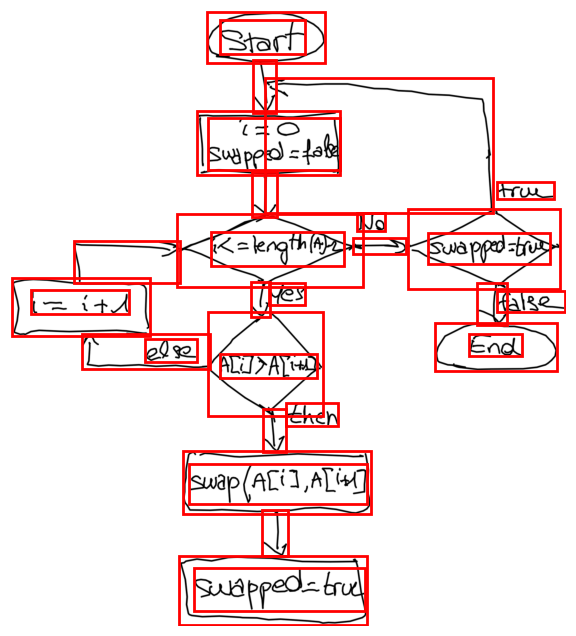

In [4]:
# Define custom dataset class
class ArrowDiagramDataset(Dataset):
    def __init__(self, image_dir, annotation_file, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        with open(annotation_file, 'r') as f:
            self.annotations = json.load(f)
        self.images = {item['id']: item for item in self.annotations['images']}
        self.annotations_dict = {}
        for ann in self.annotations['annotations']:
            img_id = ann['image_id']
            if img_id not in self.annotations_dict:
                self.annotations_dict[img_id] = []
            self.annotations_dict[img_id].append(ann)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_info = self.images[idx]
        image_path = os.path.join(self.image_dir, image_info['file_name'])
        image = Image.open(image_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        annotations = self.annotations_dict.get(idx, [])
        bboxes = [ann['bbox'] for ann in annotations]
        labels = [ann['category_id'] for ann in annotations]

        bboxes = [[x, y, x + w, y + h] for x, y, w, h in bboxes]

        bboxes = torch.tensor(bboxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)

        target = {'boxes': bboxes, 'labels': labels, 'image_id': image_info['id']}
        return image, target

# Custom collate function for DataLoader
def custom_collate_fn(batch):
    images = [item[0] for item in batch]
    targets = [item[1] for item in batch]
    return images, targets

# Plotting function to visualize bounding boxes
def plot_sample(image, target):
    fig, ax = plt.subplots(1, figsize=(8, 8))
    ax.imshow(image.permute(1, 2, 0).numpy())  # Convert [C, H, W] to [H, W, C]
    bboxes = target['boxes'].numpy()
    
    for bbox in bboxes:
        x_min, y_min, x_max, y_max = bbox
        width, height = x_max - x_min, y_max - y_min
        rect = patches.Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    
    plt.axis('off')
    plt.show()

# Initialize dataset and DataLoader
image_folder = "/kaggle/input/arrow-data/fca/train"
annotation_file = "/kaggle/input/arrow-data/fca/train.json"
transform = transforms.Compose([transforms.ToTensor()])
dataset = ArrowDiagramDataset(image_dir=image_folder, annotation_file=annotation_file, transform=transform)
dataloader = DataLoader(dataset, batch_size=5, shuffle=True, collate_fn=custom_collate_fn)

# Visualize a sample
images, targets = next(iter(dataloader))
print(images[0])
print(targets[0])
plot_sample(images[0], targets[0])


In [50]:
print(set([ann['category'] for ann in dataset.annotations['annotations']]))

{'text', 'arrow', 'terminator', 'process', 'connection', 'decision', 'data'}


In [5]:
def fix_invalid_boxes(targets):
    for target in targets:
        boxes = target['boxes']
        boxes[:, 2] = torch.clamp(boxes[:, 2], min=boxes[:, 0] + 1)
        boxes[:, 3] = torch.clamp(boxes[:, 3], min=boxes[:, 1] + 1)
    return targets


In [6]:
# Load pre-trained model and modify it for our custom dataset
dataloader = DataLoader(dataset, batch_size=10, shuffle=True, collate_fn=custom_collate_fn)
model = fasterrcnn_resnet50_fpn(pretrained=True)
num_classes = len(set([ann['category_id'] for ann in dataset.annotations['annotations']])) + 1
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define optimizer
optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.9)
epochs = 4

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
# Training loop
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    i=0
    for images, targets in dataloader:
        images = [img.to(device) for img in images]
        targets = [
            {k: (v.to(device) if isinstance(v, torch.Tensor) else v) for k, v in t.items()}
            for t in targets
        ]

        # Fix invalid boxes
        targets = fix_invalid_boxes(targets)

        # Skip iteration if no valid targets are left
        if not targets:
            continue
            
        # Forward pass
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        # Backpropagation
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        running_loss += losses.item()
        i+=1
        print(i)
    print(f"Epoch {epoch + 1}, Loss: {running_loss:.4f}")

torch.save(model.state_dict(), '/kaggle/working/arrow_frcnn_resnet.pth')

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
Epoch 1, Loss: 45.3633
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
Epoch 2, Loss: 21.0864
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
Epoch 3, Loss: 14.6348
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
Epoch 4, Loss: 11.6698


In [48]:
torch.save(model.state_dict(), '/kaggle/working/arrow_resnet.pth')

In [ ]:
model = fasterrcnn_resnet50_fpn(pretrained=True)
num_classes = len(set([ann['category_id'] for ann in dataset.annotations['annotations']])) + 1
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

model.load_state_dict(torch.load('arrow_fasterrcnn_resnet.pth'))

[[ 203.47629    122.94796    246.51651    279.0886   ]
 [ 182.2829     377.2716     228.42416    527.06104  ]
 [  66.86841    941.1665     324.23395   1029.2092   ]
 [ 140.15855    581.0732     250.98662    643.7724   ]
 [ 162.11285   1045.6802     212.08408   1188.1255   ]
 [  75.31444    291.33472    299.91663    376.76636  ]
 [  79.06351    514.14014    337.74054    739.6869   ]
 [ 163.21591     31.462605   349.0665     109.01553  ]
 [ 165.3856     735.1023     219.69743    910.2687   ]
 [  95.23526   1205.9897     207.35266   1289.5437   ]
 [ 214.67175    782.2303     338.83496    851.9161   ]
 [ 124.79242      6.4841347  383.97537    127.96553  ]
 [  36.507263  1180.0823     300.45618   1333.       ]
 [   0.         261.1844     378.82278    390.29395  ]
 [  20.04924    896.8287     414.        1052.1599   ]
 [  18.582947   897.27893    400.50552   1064.332    ]
 [  45.5551     258.3663     360.63525    387.32907  ]
 [  75.84089   1205.0455     259.68762   1318.6945   ]
 [  62.072

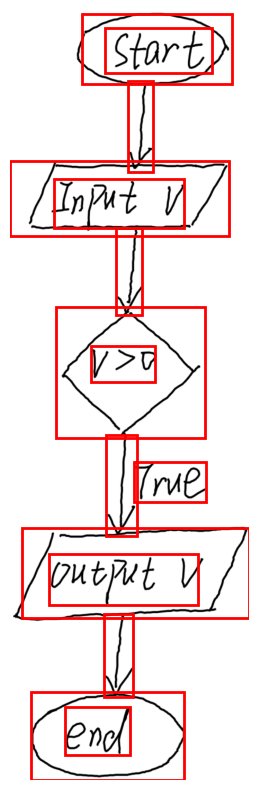

In [47]:
import torch
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torchvision import transforms

def predict_and_plot(model, image_path, threshold=0.5):
    # Load and preprocess the image
    image = Image.open(image_path).convert("RGB")
    transform = transforms.Compose([transforms.ToTensor()])
    image_tensor = transform(image).unsqueeze(0)  # Add batch dimension

    # Move the image to the same device as the model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()  # Set model to evaluation mode

    with torch.no_grad():
        predictions = model(image_tensor.to(device))[0]  # Get predictions for a single image

    # Filter predictions based on the threshold
    boxes = predictions['boxes'].cpu().numpy()
    scores = predictions['scores'].cpu().numpy()
    labels = predictions['labels'].cpu().numpy()

    print(boxes)
    print(scores)
    print(labels)
    
    filtered_boxes = [box for box, score in zip(boxes, scores) if score >= threshold]
    filtered_labels = [label for label,score in zip(labels, scores) if score >= threshold]
    print(filtered_boxes)
    print(filtered_labels)
    # Plot the image with bounding boxes
    fig, ax = plt.subplots(1, figsize=(10, 10))
    ax.imshow(image)
    for box in filtered_boxes:
        x_min, y_min, width, height = box
        rect = patches.Rectangle((x_min, y_min), width - x_min, height - y_min,
                                 linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    plt.axis('off')
    plt.show()

# Example usage
new_image_path = "/kaggle/input/arrow-data/fca/test/writer10_10b.png"  # Update with the path to a new image
predict_and_plot(model, new_image_path)


In [20]:
import cv2
import numpy as np
import pytesseract
import torch
from torchvision import transforms
from PIL import Image

In [51]:
# Function to preprocess input image
def preprocess_image(image_path):
    image = Image.open(image_path).convert("RGB")
    transform = transforms.Compose([
        transforms.ToTensor()
    ])
    return transform(image).unsqueeze(0), image

# Perform OCR using Tesseract
def extract_text(image):
    gray = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2GRAY)
    text = pytesseract.image_to_string(gray, config='--psm 6')
    return text

# Detect diagrams with the Faster R-CNN model
def detect_diagrams(image_tensor, original_image):
    with torch.no_grad():
        predictions = model(image_tensor)[0]

    # Extract bounding boxes, labels, and scores
    boxes = predictions['boxes'].numpy()
    labels = predictions['labels'].numpy()
    scores = predictions['scores'].numpy()

    print(scores)
    threshold = 0.4
    filtered_boxes = [box for box, score in zip(boxes, scores) if score >= threshold]

    # Plot the image with bounding boxes
    fig, ax = plt.subplots(1, figsize=(10, 10))
    ax.imshow(original_image)
    for box in filtered_boxes:
        x_min, y_min, width, height = box
        rect = patches.Rectangle((x_min, y_min), width - x_min, height - y_min,
                                 linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    plt.axis('off')
    plt.show()

    threshold = 0.4
    diagrams = []
    text_boxes = []

    for box, label, score in zip(boxes, labels, scores):
        if score > threshold:
            x_min, y_min, x_max, y_max = map(int, box)
            cropped_region = original_image.crop((x_min, y_min, x_max, y_max))
            if label == 1:  # Assuming label 1 is a diagram
                diagrams.append((label, cropped_region, (x_min, y_min, x_max, y_max)))
            else:  # Assume other labels might represent text regions
                text_boxes.append((label, cropped_region, (x_min, y_min, x_max, y_max)))
    return diagrams, text_boxes

# Main processing function
def process_handwritten_script(image_path):
    image_tensor, original_image = preprocess_image(image_path)

    # Detect diagrams and text boxes
    diagrams, text_boxes = detect_diagrams(image_tensor, original_image)

    if diagrams:
        print("Detected Diagrams:")
        for idx, (label, diagram_image, (x_min, y_min, x_max, y_max)) in enumerate(diagrams):
            diagram_image.show(title=f"Diagram {idx+1} - Label: {label}")

    # Mask diagram regions to prevent reading text from them
    mask = np.ones(original_image.size[::-1], dtype=np.uint8) * 255  # White mask
    for _, _, (x_min, y_min, x_max, y_max) in diagrams:
        cv2.rectangle(mask, (x_min, y_min), (x_max, y_max), color=0, thickness=-1)  # Black out diagram areas

    masked_image = Image.fromarray(cv2.bitwise_and(np.array(original_image), np.array(original_image), mask=mask))

    print("Extracting text from non-diagram regions:")
    non_diagram_text = extract_text(masked_image)
    print("\nExtracted Text outside Diagrams:")
    print(non_diagram_text)

    print("\nExtracting text from diagram-annotated text regions:")
    extracted_text = []
    for label, text_image, (x_min, y_min, x_max, y_max) in text_boxes:
        ocr_result = extract_text(text_image)
        extracted_text.append(f"Text Box {label}: {ocr_result.strip()} (Position: {x_min}, {y_min}, {x_max}, {y_max})")

    if extracted_text:
        print("\nExtracted Text from Text Boxes:")
        for text_entry in extracted_text:
            print(text_entry)
    else:
        print("No text regions detected by the model.")


[0.9853715  0.9714826  0.9683141  0.9554724  0.95413077 0.9488549
 0.9462026  0.9441155  0.9412088  0.901281   0.8971066  0.8708048
 0.8635501  0.85782045 0.8541767  0.8203148  0.8135537  0.8108421
 0.798218   0.7770222  0.7632718  0.71153843 0.6939409  0.6610521
 0.6298723  0.62282765 0.61651325 0.60388863 0.60230875 0.5788759
 0.574628   0.5732443  0.5665589  0.55648136 0.52836835 0.50933707
 0.47113678 0.46094757 0.43068698 0.4169613  0.39728794 0.39494345
 0.39085492 0.35743394 0.29718003 0.2921794  0.2892134  0.278294
 0.26596528 0.2558915  0.25534868 0.2512257  0.22745755 0.21876588
 0.21083115 0.19421    0.18475315 0.17366126 0.17350148 0.17311993
 0.16351639 0.16280593 0.15706918 0.15311365 0.14208673 0.13800581
 0.13500796 0.13380314 0.13234548 0.13020349 0.12269794 0.12259193
 0.12088773 0.11716858 0.11460847 0.10875634 0.10568964 0.10072824
 0.10031457 0.09991375 0.09098359 0.09069787 0.08410317 0.080848
 0.07963029 0.07931168 0.07771181 0.07691743 0.07662479 0.07630605
 0.0

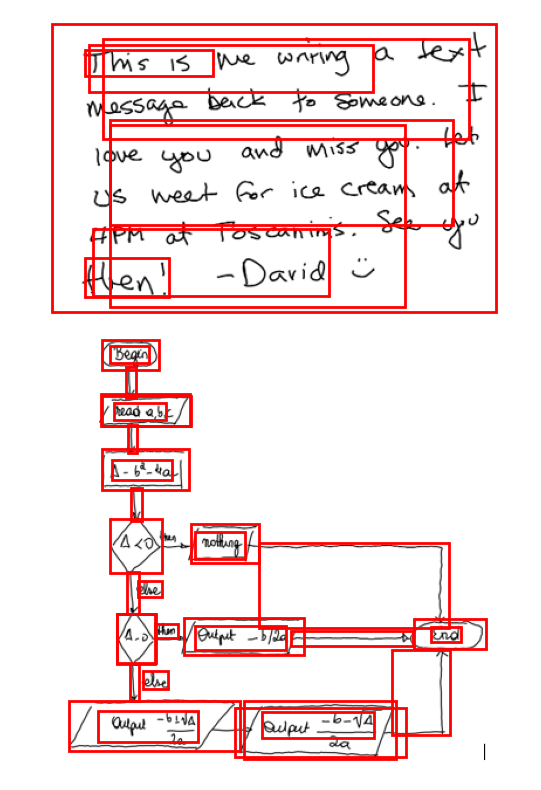

Detected Diagrams:
Extracting text from non-diagram regions:

Extracted Text outside Diagrams:
This 1s we wring a bert
massage. beck fo Swen. 1
Jove You ond miss a ler
DS weak Ger ica Crtam, ok
LEPM ok Toscanims- Fea, xe
Lhen! David &
[A H-4au|
dees
dhe
fs se-/ dit —b/da ind)
che.
|


Extracting text from diagram-annotated text regions:

Extracted Text from Text Boxes:
Text Box 6: | (Position: 212, 454, 374, 528)
Text Box 6: | (Position: 325, 546, 375, 619)
Text Box 5: pe (Position: 112, 564, 134, 580)
Text Box 5: ae. (Position: 109, 487, 128, 500)
Text Box 6: | (Position: 98, 304, 107, 330)
Text Box 2:  (Position: 85, 434, 129, 480)
Text Box 3: A- Hae (Position: 78, 374, 152, 409)
Text Box 6: { (Position: 100, 354, 108, 377)
Text Box 6: \ (Position: 102, 408, 112, 435)
Text Box 6: f+ (Position: 239, 530, 344, 543)
Text Box 6: | (Position: 101, 558, 109, 590)
Text Box 5: bila
Quip ~ bs (Position: 74, 598, 160, 624)
Text Box 5: tnd (Position: 359, 526, 385, 539)
Text Box 5: ~b-y4
Quav 

In [52]:
# Example usage
if __name__ == "__main__":
    image_path = "/kaggle/input/handwrittennotes-test1/Screenshot 2025-01-17 103521.png"  # Path to input image
    process_handwritten_script(image_path)